In [1734]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import scipy.io as sio
import numpy as np
import pandas as pd

### Fine Tuning

In [1735]:
def get_lag_llama_predictions(dataset, prediction_length, context_length, num_samples, device, batch_size, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    # print(forecast_it, ts_it)
    forecasts = list(tqdm(forecast_it, total=len(dataset)))
    tss = list(tqdm(ts_it, total=len(dataset)))

    return forecasts, tss

In [1736]:
data = sio.loadmat('D:\\ly\\sEMG\\SIAT-UPS\\emg_features_examples.mat')

semg_data = data['examples']  # shape: (samples, 9, 6)
joint_angles = data['angle_labels']  # shape: (samples, 8)
joint_torques = data['torque_labels']  # shape: (samples, 8)

angles_name = data['angle_name']
torques_name = data['torque_name']

# 重塑sEMG数据
semg_reshaped = semg_data.reshape(semg_data.shape[0], -1)  # shape: (samples, 54)

# 创建时间索引
num_samples = semg_data.shape[0]
sampling_rate = 1926  # f'{1000/sampling_rate:.3f}ms'
time_index = pd.timedelta_range(start='0', 
                                periods=num_samples, 
                                freq=f'{1000/sampling_rate:.3f}ms')

# 创建DataFrame
df = pd.DataFrame(
    np.hstack((joint_angles, semg_reshaped, joint_torques)),
    index=time_index,
    columns=[f'{angles_name[i]}' for i in range(8)] + [f'semg_{i}' for i in range(54)] + [f'{torques_name[i]}' for i in range(8)]
)
df.index = df.index.total_seconds()
df

,left hip adduction,left hip flexion,left knee flexion,left ankle flexion,right hip adduction,right hip flexion,right knee flexion,right ankle flexion,semg_0,semg_1,...,semg_52,semg_53,left hip adduction torque,left hip flexion torque,left knee flexion torque,left ankle flexion torque,right hip adduction torque,right hip flexion torque,right knee flexion torque,right ankle flexion torque
0.000000,-2.911356,38.685166,92.807369,13.114965,-2.108089,26.361162,35.455239,-1.194237,0.464151,0.000033,...,1.0,81.0,-12.291363,15.570726,0.331848,5.698510,-40.170709,-30.408407,-66.165885,-10.026001
0.000519,-3.916039,39.976656,94.446092,10.574270,-1.639000,25.718500,36.043649,-0.575133,0.458580,0.000032,...,0.0,87.0,-11.270131,16.087237,-1.825978,6.062143,-42.344766,-26.181394,-71.583512,-7.551678
0.001038,-4.704382,41.145805,94.759461,9.079517,-1.245771,25.145880,36.316621,-0.087085,0.349124,0.000022,...,0.0,86.0,-10.280912,16.562719,-3.546804,6.066180,-42.859676,-23.273704,-72.653933,-5.573360
0.001557,-5.167445,42.142139,93.638669,8.519608,-0.998886,24.654968,36.353371,0.334465,0.338890,0.000019,...,0.0,85.0,-9.724392,16.909505,-4.391324,5.928014,-42.396313,-24.082428,-69.565141,-3.891667
0.002076,-5.279042,42.912946,91.085285,8.425922,-0.915321,24.233310,36.239775,0.765962,0.695603,0.000077,...,0.0,87.0,-10.077636,17.209314,-4.359085,5.822574,-41.532447,-25.538030,-65.141425,-1.583036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.352493,-3.552101,29.971559,58.804591,-1.473442,-1.000199,2.639377,19.435343,8.386818,0.143894,0.000003,...,3.0,90.0,-3.757517,0.651826,4.095271,1.988317,-21.119843,-2.046989,-2.666608,-54.869099
10.353012,-3.133334,28.192172,50.343723,-5.027025,-0.978156,2.092506,19.864062,8.986606,0.134094,0.000003,...,2.0,85.0,-3.885409,-0.470513,5.361873,2.137944,-20.844920,-0.465285,-2.357848,-58.259503
10.353531,-2.773739,25.794942,41.727031,-8.542155,-0.847580,1.626593,20.943839,9.811705,0.137239,0.000003,...,2.0,90.0,-3.392870,-3.119011,6.809699,2.586792,-21.406693,3.405630,-4.794125,-62.016538
10.354050,-2.595149,22.963306,33.396294,-11.767030,-0.610220,1.333837,22.751226,10.850543,0.140257,0.000003,...,3.0,92.0,-2.848430,-6.010877,8.151218,2.526886,-21.425267,8.116903,-9.237328,-65.692862


In [1820]:
from gluonts.dataset.common import ListDataset

def prepare_data_for_gluonts(df):
    target_variables = [f'{torques_name[7]}']
    # target_variables = [f'{angles_name[i]}' for i in range(8)]
    # target_variables = [f'{torques_name[i]}' for i in range(8)]

    # 创建一个字典来存储每个目标变量的时间序列
    data = []
    for var in target_variables:
        ts = {
            "target": df[var].values,
            "start": pd.Timestamp("2023-01-01"),  # 使用一个任意的开始日期
            "item_id": var
        }
        data.append(ts)
    return ListDataset(data, freq='1ms')  # 假设频率是1ms f'{1000/sampling_rate:.3f}ms'

# 准备数据
gluonts_dataset = prepare_data_for_gluonts(df)
gluonts_dataset

[{'target': array([-10.026001,  -7.551678,  -5.57336 , ..., -62.016537, -65.69286 ,
         -68.969734], dtype=float32),
  'start': Period('2023-01-01 00:00:00.000', 'L'),
  'item_id': 'right ankle flexion torque'}]

### finetuning

In [1821]:
from gluonts.dataset.common import ListDataset
import pandas as pd
import numpy as np

def split_long_timeseries(dataset, train_ratio, freq):
    first_item = dataset[0]
    total_length = len(first_item["target"])
    
    # 计算训练集的长度
    train_length = int(total_length * train_ratio)
    
    train_data = []
    test_data = []
    
    for item in dataset:
        train_item = {
            "target": item["target"][:train_length],
            "start": item["start"],
            "item_id": item["item_id"]
        }
        test_item = {
            "target": item["target"][train_length:],
            "start": item["start"] + pd.Timedelta(milliseconds=2*train_length),
            "item_id": item["item_id"]
        }
        train_data.append(train_item)
        test_data.append(test_item)
    
    train_dataset = ListDataset(train_data, freq=freq)
    test_dataset = ListDataset(test_data, freq=freq)
    
    return train_dataset, test_dataset

# truncated_dataset = truncate_dataset(gluonts_dataset, last_n=1000)
# truncated_dataset = truncate_dataset_head(gluonts_dataset, first_n=5000)
train_dataset, test_dataset = split_long_timeseries(gluonts_dataset, train_ratio=0.8, freq=f'1ms')

print(f"训练集时间长度: {len(train_dataset[0]['target'])}")
print(f"测试集时间长度: {len(test_dataset[0]['target'])}")

训练集时间长度: 15961
测试集时间长度: 3991


In [1829]:
prediction_length = 128
context_length = prediction_length*4
device = 'cuda'
num_samples = 20
epoch = 50 # step = epoch * 50
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=False,
        aug_prob=0,
        lr=5e-4,  # 1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4?  5e-4

        # estimator args
        input_size=estimator_args["input_size"], # 特征值
        n_layer=estimator_args["n_layer"],  # 层数 4\6\8\12\16
        n_embd_per_head=estimator_args["n_embd_per_head"],  # 每个attention头的嵌入维度 32\64\128\256
        n_head=estimator_args["n_head"],  # attention头数 4\8\16
        time_feat=estimator_args["time_feat"],

        rope_scaling={
             "type": "linear",
             "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
         },

        batch_size=16,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": epoch,}, # <- lightning trainer arguments
    )

estimator_args["n_layer"], estimator_args["n_embd_per_head"], estimator_args["n_head"]

C:\Users\linhy\AppData\Local\Temp\ipykernel_13364\2120087043.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


(8, 16, 9)

In [1830]:
predictor = estimator.train(train_dataset, cache_data=True)

d:\Anaconda3\envs\SIAT-ModelTest\Lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
GPU available: True (cuda), used: True
TPU availab

Epoch 0: |          | 50/? [00:01<00:00, 27.16it/s, v_num=200]

Epoch 0, global step 50: 'train_loss' reached 3.20033 (best 3.20033), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 31.46it/s, v_num=200]

Epoch 1, global step 100: 'train_loss' reached 2.73694 (best 2.73694), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 31.71it/s, v_num=200]

Epoch 2, global step 150: 'train_loss' reached 2.36586 (best 2.36586), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 31.07it/s, v_num=200]

Epoch 3, global step 200: 'train_loss' reached 2.35770 (best 2.35770), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 30.79it/s, v_num=200]

Epoch 4, global step 250: 'train_loss' reached 2.26706 (best 2.26706), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 30.75it/s, v_num=200]

Epoch 5, global step 300: 'train_loss' reached 1.88073 (best 1.88073), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 30.46it/s, v_num=200]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 30.97it/s, v_num=200]

Epoch 7, global step 400: 'train_loss' reached 1.79400 (best 1.79400), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:01<00:00, 31.33it/s, v_num=200]

Epoch 8, global step 450: 'train_loss' reached 1.69870 (best 1.69870), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:01<00:00, 31.07it/s, v_num=200]

Epoch 9, global step 500: 'train_loss' reached 1.59511 (best 1.59511), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:01<00:00, 30.32it/s, v_num=200]

Epoch 10, global step 550: 'train_loss' reached 1.49790 (best 1.49790), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:01<00:00, 29.06it/s, v_num=200]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 28.99it/s, v_num=200]

Epoch 12, global step 650: 'train_loss' reached 1.45196 (best 1.45196), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:01<00:00, 29.10it/s, v_num=200]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 29.20it/s, v_num=200]

Epoch 14, global step 750: 'train_loss' reached 1.33104 (best 1.33104), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:01<00:00, 29.02it/s, v_num=200]

Epoch 15, global step 800: 'train_loss' reached 1.30787 (best 1.30787), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:01<00:00, 29.30it/s, v_num=200]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 29.43it/s, v_num=200]

Epoch 17, global step 900: 'train_loss' reached 1.28270 (best 1.28270), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:01<00:00, 29.06it/s, v_num=200]

Epoch 18, global step 950: 'train_loss' reached 1.16489 (best 1.16489), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:01<00:00, 29.36it/s, v_num=200]

Epoch 19, global step 1000: 'train_loss' reached 1.10700 (best 1.10700), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:01<00:00, 29.16it/s, v_num=200]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 29.24it/s, v_num=200]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 29.44it/s, v_num=200]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 29.20it/s, v_num=200]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 27.83it/s, v_num=200]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 28.30it/s, v_num=200]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 28.49it/s, v_num=200]

Epoch 26, global step 1350: 'train_loss' reached 1.02096 (best 1.02096), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:01<00:00, 29.51it/s, v_num=200]

Epoch 27, global step 1400: 'train_loss' reached 1.00480 (best 1.00480), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:01<00:00, 29.24it/s, v_num=200]

Epoch 28, global step 1450: 'train_loss' reached 0.96657 (best 0.96657), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:01<00:00, 29.16it/s, v_num=200]

Epoch 29, global step 1500: 'train_loss' reached 0.88964 (best 0.88964), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:01<00:00, 29.55it/s, v_num=200]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 29.45it/s, v_num=200]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 28.41it/s, v_num=200]

Epoch 32, global step 1650: 'train_loss' reached 0.82770 (best 0.82770), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:01<00:00, 29.18it/s, v_num=200]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 29.20it/s, v_num=200]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 28.97it/s, v_num=200]

Epoch 35, global step 1800: 'train_loss' reached 0.80612 (best 0.80612), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:01<00:00, 29.31it/s, v_num=200]

Epoch 36, global step 1850: 'train_loss' reached 0.79971 (best 0.79971), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:01<00:00, 29.36it/s, v_num=200]

Epoch 37, global step 1900: 'train_loss' reached 0.79722 (best 0.79722), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:01<00:00, 29.05it/s, v_num=200]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 29.11it/s, v_num=200]

Epoch 39, global step 2000: 'train_loss' reached 0.70100 (best 0.70100), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:01<00:00, 29.30it/s, v_num=200]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 29.10it/s, v_num=200]

Epoch 41, global step 2100: 'train_loss' reached 0.64479 (best 0.64479), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:01<00:00, 29.08it/s, v_num=200]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 29.34it/s, v_num=200]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 28.49it/s, v_num=200]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 28.41it/s, v_num=200]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 28.75it/s, v_num=200]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 28.99it/s, v_num=200]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 28.66it/s, v_num=200]

Epoch 48, global step 2450: 'train_loss' reached 0.63825 (best 0.63825), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:01<00:00, 29.46it/s, v_num=200]

Epoch 49, global step 2500: 'train_loss' reached 0.63206 (best 0.63206), saving model to 'd:\\ly\\sEMG\\SIAT\\lag-llama\\lightning_logs\\version_200\\checkpoints\\epoch=49-step=2500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:01<00:00, 26.19it/s, v_num=200]

d:\Anaconda3\envs\SIAT-ModelTest\Lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [1831]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=num_samples
)
forecasts = list(tqdm(forecast_it, desc="Forecasting batches"))
tss = list(tqdm(ts_it, desc="Ground truth"))

Forecasting batches: 1it [00:01,  1.39s/it]
Ground truth: 1it [00:00, ?it/s]


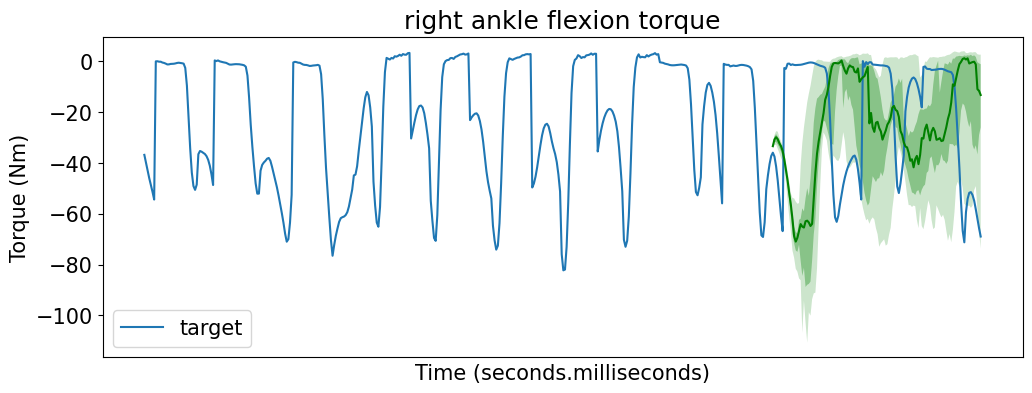

In [1832]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})
for idx, (forecast, ts) in enumerate(zip(forecasts, tss)):
    ax = plt.subplot(4, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot( color='g')
    ax.set_xticks([])
    ax.set_title(forecast.item_id)
    ax.set_xlabel('Time (seconds.milliseconds)')
    # ax.set_ylabel('Angle (°)')
    ax.set_ylabel('Torque (Nm)')

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [1835]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

print("prediction_length:", prediction_length)
print("context_length: ", context_length)
print("device: ", device)
print("num_samples: ", num_samples)
print("epoch: ", epoch)

print("CRPS:", agg_metrics['mean_wQuantileLoss'])
print("RMSE:", agg_metrics['RMSE'])
agg_metrics

Running evaluation: 1it [00:00, 200.50it/s]

prediction_length: 128
context_length:  512
device:  cuda
num_samples:  20
epoch:  50
CRPS: 1.223745831377557
RMSE: 35.8253532099432


{'MSE': 1283.4559326171875,
 'abs_error': 4307.90234375,
 'abs_target_sum': 2716.169677734375,
 'abs_target_mean': 21.220075607299805,
 'seasonal_error': 2.8453094150537286,
 'MASE': 11.82841025390251,
 'MAPE': 14.419305801391602,
 'sMAPE': 1.4764988422393799,
 'MSIS': 111.56478752453607,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1949.51676902771,
 'Coverage[0.1]': 0.3203125,
 'QuantileLoss[0.2]': 2896.7311725616455,
 'Coverage[0.2]': 0.3515625,
 'QuantileLoss[0.3]': 3832.20700340271,
 'Coverage[0.3]': 0.3671875,
 'QuantileLoss[0.4]': 4322.011589431762,
 'Coverage[0.4]': 0.3828125,
 'QuantileLoss[0.5]': 4307.9023896455765,
 'Coverage[0.5]': 0.40625,
 'QuantileLoss[0.6]': 4237.304783725738,
 'Coverage[0.6]': 0.4140625,
 'QuantileLoss[0.7]': 3647.265186595917,
 'Coverage[0.7]': 0.4453125,
 'QuantileLoss[0.8]': 2787.5241880893705,
 'Coverage[0.8]': 0.6171875,
 'QuantileLoss[0.9]': 1934.6488014936447,
 'Coverage[0.9]': 0.734375,
 'RMSE': 35.8253532099432,
 'NRMSE': 1.68827641